In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-04-14 14:40:49'

# Trace conditioning task

- Run sweeps for 10 seeds per config for 10m steps. Only the configs where all seeds converge are considered when picking the best.
- Pick the best configs, run them for 30 seeds for 100m steps to evaluate asymptotic performance

In [1]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    })

# some irrelavant config
#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [3]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False, gc2=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='haseeb',
                                            password=os.environ['gcpswd'],
                                            host='35.203.89.152',
                                            database=db_name)
            elif gc2:
                self.conn = mariadb.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [4]:
db1 = DbAccessor('hshah1_0091_tc_animal_sweep_tbptt', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db1.conn)

features  lambda                        name    run  seed  step_size  \
0            2   0.990  0091_tc_animal_sweep_tbptt      0     0     0.0005   
1            3   0.990  0091_tc_animal_sweep_tbptt      1     0     0.0005   
2            5   0.990  0091_tc_animal_sweep_tbptt      2     0     0.0005   
3           10   0.990  0091_tc_animal_sweep_tbptt      3     0     0.0005   
4            2   0.999  0091_tc_animal_sweep_tbptt      4     0     0.0005   
...        ...     ...                         ...    ...   ...        ...   
6715        10   0.990  0091_tc_animal_sweep_tbptt  14315     9     0.2000   
6716         2   0.999  0091_tc_animal_sweep_tbptt  14316     9     0.2000   
6717         3   0.999  0091_tc_animal_sweep_tbptt  14317     9     0.2000   
6718         5   0.999  0091_tc_animal_sweep_tbptt  14318     9     0.2000   
6719        10   0.999  0091_tc_animal_sweep_tbptt  14319     9     0.2000   

         steps  truncation  
0     10000000          27  
1     10000000          27  
2     10000000          27  
3     10000000          27  
4     10000000          27  
...        ...         ...  
6715  10000000          27  
6716  10000000          27  
6717  10000000          27  
6718  10000000          27  
6719  10000000          27  

[6720 rows x 8 columns]

In [5]:
db2 = DbAccessor('hshah1_0090_tc_animal_sweep', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db2.conn)

features        freq  lambda                  name   run  seed  start  \
0            2  1000000000   0.990  0090_tc_animal_sweep     0     0      0   
1            3  1000000000   0.990  0090_tc_animal_sweep     1     0      0   
2            5  1000000000   0.990  0090_tc_animal_sweep     2     0      0   
3           10  1000000000   0.990  0090_tc_animal_sweep     3     0      0   
4            2  1000000000   0.999  0090_tc_animal_sweep     4     0      0   
...        ...         ...     ...                   ...   ...   ...    ...   
3195        10  1000000000   0.990  0090_tc_animal_sweep  3195     9      0   
3196         2  1000000000   0.999  0090_tc_animal_sweep  3196     9      0   
3197         3  1000000000   0.999  0090_tc_animal_sweep  3197     9      0   
3198         5  1000000000   0.999  0090_tc_animal_sweep  3198     9      0   
3199        10  1000000000   0.999  0090_tc_animal_sweep  3199     9      0   

      std_cap  step_size     steps  width  
0     0.01000     0.0005  10000000     10  
1     0.01000     0.0005  10000000     10  
2     0.01000     0.0005  10000000     10  
3     0.01000     0.0005  10000000     10  
4     0.01000     0.0005  10000000     10  
...       ...        ...       ...    ...  
3195  0.00001     0.0050  10000000     10  
3196  0.00001     0.0050  10000000     10  
3197  0.00001     0.0050  10000000     10  
3198  0.00001     0.0050  10000000     10  
3199  0.00001     0.0050  10000000     10  

[3200 rows x 11 columns]

In [21]:
db3 = DbAccessor('hshah1_0092_animal_asymptotic', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db3.conn)

features        freq  lambda                    name  run  seed  start  \
0         10  1000000000   0.999  0092_animal_asymptotic    0     0      0   
1         10  1000000000   0.999  0092_animal_asymptotic    1     1      0   
2         10  1000000000   0.999  0092_animal_asymptotic    2     2      0   
3         10  1000000000   0.999  0092_animal_asymptotic    3     3      0   
4         10  1000000000   0.999  0092_animal_asymptotic    4     4      0   
5         10  1000000000   0.999  0092_animal_asymptotic    5     5      0   
6         10  1000000000   0.999  0092_animal_asymptotic    6     6      0   
7         10  1000000000   0.999  0092_animal_asymptotic    7     7      0   
8         10  1000000000   0.999  0092_animal_asymptotic    8     8      0   
9         10  1000000000   0.999  0092_animal_asymptotic    9     9      0   
10        10  1000000000   0.999  0092_animal_asymptotic   10    10      0   
11        10  1000000000   0.999  0092_animal_asymptotic   11    11      0   
12        10  1000000000   0.999  0092_animal_asymptotic   12    12      0   
13        10  1000000000   0.999  0092_animal_asymptotic   13    13      0   
14        10  1000000000   0.999  0092_animal_asymptotic   14    14      0   
15        10  1000000000   0.999  0092_animal_asymptotic   15    15      0   
16        10  1000000000   0.999  0092_animal_asymptotic   16    16      0   
17        10  1000000000   0.999  0092_animal_asymptotic   17    17      0   
18        10  1000000000   0.999  0092_animal_asymptotic   18    18      0   
19        10  1000000000   0.999  0092_animal_asymptotic   19    19      0   
20        10  1000000000   0.999  0092_animal_asymptotic   20    20      0   
21        10  1000000000   0.999  0092_animal_asymptotic   21    21      0   
22        10  1000000000   0.999  0092_animal_asymptotic   22    22      0   
23        10  1000000000   0.999  0092_animal_asymptotic   23    23      0   
24        10  1000000000   0.999  0092_animal_asymptotic   24    24      0   
25        10  1000000000   0.999  0092_animal_asymptotic   25    25      0   
26        10  1000000000   0.999  0092_animal_asymptotic   26    26      0   
27        10  1000000000   0.999  0092_animal_asymptotic   27    27      0   
28        10  1000000000   0.999  0092_animal_asymptotic   28    28      0   
29        10  1000000000   0.999  0092_animal_asymptotic   29    29      0   
30         5  1000000000   0.999  0092_animal_asymptotic   30     0      0   
31         5  1000000000   0.999  0092_animal_asymptotic   31     1      0   
32         5  1000000000   0.999  0092_animal_asymptotic   32     2      0   
33         5  1000000000   0.999  0092_animal_asymptotic   33     3      0   
34         5  1000000000   0.999  0092_animal_asymptotic   34     4      0   
35         5  1000000000   0.999  0092_animal_asymptotic   35     5      0   
36         5  1000000000   0.999  0092_animal_asymptotic   36     6      0   
37         5  1000000000   0.999  0092_animal_asymptotic   37     7      0   
38         5  1000000000   0.999  0092_animal_asymptotic   38     8      0   
39         5  1000000000   0.999  0092_animal_asymptotic   39     9      0   
40         5  1000000000   0.999  0092_animal_asymptotic   40    10      0   
41         5  1000000000   0.999  0092_animal_asymptotic   41    11      0   
42         5  1000000000   0.999  0092_animal_asymptotic   42    12      0   
43         5  1000000000   0.999  0092_animal_asymptotic   43    13      0   
44         5  1000000000   0.999  0092_animal_asymptotic   44    14      0   
45         5  1000000000   0.999  0092_animal_asymptotic   45    15      0   
46         5  1000000000   0.999  0092_animal_asymptotic   46    16      0   
47         5  1000000000   0.999  0092_animal_asymptotic   47    17      0   
48         5  1000000000   0.999  0092_animal_asymptotic   48    18      0   
49         5  1000000000   0.999  0092_animal_asymptotic   49    19      0   
50         5  1000000000  

In [22]:
db4 = DbAccessor('hshah1_0093_animal_asymptotic_tbptt', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db4.conn)

features  lambda                          name  run  seed  step_size  \
0           2   0.999  0093_animal_asymptotic_tbptt    0     0       0.06   
1           2   0.999  0093_animal_asymptotic_tbptt    1     1       0.06   
2           2   0.999  0093_animal_asymptotic_tbptt    2     2       0.06   
3           2   0.999  0093_animal_asymptotic_tbptt    3     3       0.06   
4           2   0.999  0093_animal_asymptotic_tbptt    4     4       0.06   
..        ...     ...                           ...  ...   ...        ...   
115        10   0.999  0093_animal_asymptotic_tbptt  125     5       0.06   
116        10   0.999  0093_animal_asymptotic_tbptt  126     6       0.06   
117        10   0.999  0093_animal_asymptotic_tbptt  127     7       0.06   
118        10   0.999  0093_animal_asymptotic_tbptt  128     8       0.06   
119        10   0.999  0093_animal_asymptotic_tbptt  129     9       0.06   

         steps  truncation  
0    100000000          27  
1    100000000          27  
2    100000000          27  
3    100000000          27  
4    100000000          27  
..         ...         ...  
115  100000000          27  
116  100000000          27  
117  100000000          27  
118  100000000          27  
119  100000000          27  

[120 rows x 8 columns]

In [11]:
db5 = DbAccessor('hshah1_0094_tc_animal_sweep_bigger', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db5.conn)

features        freq  lambda                         name  run  seed  \
0         100  1000000000   0.990  0094_tc_animal_sweep_bigger    0     0   
1         100  1000000000   0.999  0094_tc_animal_sweep_bigger    1     0   
2         100  1000000000   0.990  0094_tc_animal_sweep_bigger    2     1   
3         100  1000000000   0.999  0094_tc_animal_sweep_bigger    3     1   
4         100  1000000000   0.990  0094_tc_animal_sweep_bigger    4     2   
..        ...         ...     ...                          ...  ...   ...   
151       100  1000000000   0.999  0094_tc_animal_sweep_bigger  151     5   
152       100  1000000000   0.990  0094_tc_animal_sweep_bigger  152     6   
153       100  1000000000   0.999  0094_tc_animal_sweep_bigger  153     6   
154       100  1000000000   0.990  0094_tc_animal_sweep_bigger  154     7   
155       100  1000000000   0.999  0094_tc_animal_sweep_bigger  155     7   

     start  std_cap  step_size     steps  width  
0        0  0.01000     0.0005  10000000    100  
1        0  0.01000     0.0005  10000000    100  
2        0  0.01000     0.0005  10000000    100  
3        0  0.01000     0.0005  10000000    100  
4        0  0.01000     0.0005  10000000    100  
..     ...      ...        ...       ...    ...  
151      0  0.00001     0.0006  10000000    100  
152      0  0.00001     0.0006  10000000    100  
153      0  0.00001     0.0006  10000000    100  
154      0  0.00001     0.0006  10000000    100  
155      0  0.00001     0.0006  10000000    100  

[156 rows x 11 columns]

In [13]:
pd.read_sql(f'select avg(error) from error_table where step=99970000 and run>30', db3.conn)

avg(error)
0    0.002977

In [14]:
def plt_with_err(comment, NSTEPS, min_steps, db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if table == 'training_metrics':
        col = 'running_acc'
    elif table == 'error_table' or table == "test_accuracy":
        col = 'error'
    else:
        col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

        
    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        plt.plot(x_axis, acc_mean, label=f"{label} | valid runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        #plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.16, color=color, edgecolor=None)
    return True

# Columnar Sweep

In [147]:
db2 = DbAccessor('hshah1_0090_tc_animal_sweep', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
db=db2
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(4,4, figsize=(50,32), dpi=200)
plt.xlabel('alpha')
plt.ylabel('error')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')
print(f'{"params" :^15}{"features" :^8} {"std_cap" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for std_cap in [0.01, 0.001, 0.0001, 0.00001]:
    for features in [2,3,5,10]:
        colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
        color_idx = 0
        mean_errors = []
        runs = pd.read_sql(f'select run, step_size, lambda from runs where width=10 and features={features} and std_cap={std_cap}', db.conn)
        p1 = np.unique(runs.values[:,1])
        p2 = np.unique(runs.values[:,2])
        for p in itertools.product(p1,p2):
            all_errors = []
            r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
            for run in r["run"].values:
                errors_list = pd.read_sql(f'select error from error_table where run={run}', db.conn).values
                if len(errors_list) >= 200:
                    all_errors.append(errors_list[199][0])
            all_errors = list(filter(lambda v: v==v, all_errors))
            if len(all_errors) >= total_runs_per_config:
                mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
            print(f'{str(p) :^15} {features :^8} {std_cap :^10} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
        #pd.read_sql(f'select error from error_table where run=0', db1.conn).values[400]
        r["run"].values
        mean_errors = np.array(mean_errors)

        for p in p2:
            values = mean_errors[mean_errors[:,1] == p]
            axs[i,j].plot(values[:,0], values[:,2], label=f"λ:{p}", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
            axs[i,j].set_ylim(bottom=0.002, top=0.02)
            axs[i,j].legend(prop={'size': 10})
            axs[i,j].set_title(f"features: {features}, std_cap: {std_cap}")
            axs[i,j].set_xticks(values[:,0])
            axs[i,j].set_xticklabels(values[:,0], rotation=90, fontsize=10)
            color_idx += 1
        i+=1
        print("\n")
    j+=1
    i=0

plt.show()

    params     features  std_cap                                                                                                  all_errors                                                                                                   mean    total runs
(0.0005, 0.99)     2        0.01                                                      [0.008893, 0.010926, 0.014098, 0.009037, 0.008499, 0.011981, 0.010313, 0.004333, 0.011177, 0.012562]                                                    0.01018       10    
(0.0005, 0.999)    2        0.01                                                      [0.010192, 0.009581, 0.014437, 0.008982, 0.008704, 0.01174, 0.010399, 0.004101, 0.010967, 0.010656]                                                     0.00998       10    
(0.0006, 0.99)     2        0.01                                                       [0.011171, 0.010048, 0.0133, 0.009445, 0.008532, 0.012768, 0.010618, 0.004246, 0.011158, 0.010557]                                       

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 (0.003, 0.99)     5       1e-05                                                                                                       []                                                                                                       nan         0     
(0.003, 0.999)     5       1e-05                                                                                              [0.00943, 0.005893]                                                                                             0.00766       2     
 (0.004, 0.99)     5       1e-05                                                                                              [0.006121, 0.007403]                                                                                            0.00676       2     
(0.004, 0.999)     5       1e-05                                                                                                   [0.014162]                                                                                  

/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haseebs/workspace/envs/animal/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 (0.002, 0.99)     10      1e-05                                                                                                       []                                                                                                       nan         0     
(0.002, 0.999)     10      1e-05                                                                                                   [0.006128]                                                                                                 0.00613       1     
 (0.003, 0.99)     10      1e-05                                                                                                       []                                                                                                       nan         0     
(0.003, 0.999)     10      1e-05                                                                                                       []                                                                                      

# T-BPTT Sweep

In [144]:
db1 = DbAccessor('hshah1_0091_tc_animal_sweep_tbptt', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
db=db1
total_runs_per_config = 10
markers = ['.',8,'s','p','*','h', 1,2,3,4]
marker_idx = 0
i = 0
j = 0

fig, axs = plt.subplots(4,3, figsize=(50,32), dpi=200)
plt.xlabel('alpha')
plt.ylabel('error')
plt.xscale('linear')
plt.xticks(rotation=90)
plt.xticks(fontsize= 5)
fig.axes[0].set_ylim(bottom=0.002, top=0.02)
#legend = plt.legend(prop={'size': 10})
#frame = legend.get_frame()
#frame.set_linewidth(0.6)
#frame.set_boxstyle('Square')

print(f'{"params" :^15}{"features" :^8} {"truncation" :^10} {"all_errors":^200} {"mean" :^10} {"total runs" :^10}')
for truncation in [27,13,6]:
    for features in [2,3,5,10]:
        colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']
        color_idx = 0
        mean_errors = []
        runs = pd.read_sql(f'select run, step_size, lambda from runs where features={features} and truncation={truncation}', db.conn)
        p1 = np.unique(runs.values[:,1])
        p2 = np.unique(runs.values[:,2])
        for p in itertools.product(p1,p2):
            all_errors = []
            r = runs[(runs["step_size"] == p[0]) & (runs["lambda"] == p[1])]
            for run in r["run"].values:
                errors_list = pd.read_sql(f'select error from error_table where run={run}', db.conn).values
                if len(errors_list) >= 200:
                    all_errors.append(errors_list[199][0])
            all_errors = list(filter(lambda v: v==v, all_errors))
            if len(all_errors) >= total_runs_per_config:
                mean_errors.append(np.concatenate((p, [np.mean(all_errors)])))
            print(f'{str(p) :^15} {features :^8} {truncation :^10} {str(all_errors) :^200} {np.mean(all_errors) :^10.5f} {len(all_errors) :^10}')
        r["run"].values
        mean_errors = np.array(mean_errors)

        for p in p2:
            values = mean_errors[mean_errors[:,1] == p]
            axs[i,j].plot(values[:,0], values[:,2], label=f"λ:{p}", color=colors[color_idx], linewidth=1, marker=markers[marker_idx])#, markersize=2)
            axs[i,j].set_ylim(bottom=0.002, top=0.02)
            axs[i,j].legend(prop={'size': 10})
            axs[i,j].set_title(f"features: {features}, truncation: {truncation}")
            axs[i,j].set_xticks(values[:,0])
            axs[i,j].set_xticklabels(values[:,0], rotation=90, fontsize=7)
            color_idx += 1
        i+=1
        print("\n")
    j+=1
    i=0

plt.show()

    params     features truncation                                                                                                all_errors                                                                                                   mean    total runs
(0.0005, 0.99)     2         27                                                        [0.022425, 0.019007, 0.02204, 0.020001, 0.02177, 0.022548, 0.019815, 0.019212, 0.020761, 0.021227]                                                     0.02088       10    
(0.0005, 0.999)    2         27                                                       [0.022416, 0.019008, 0.022039, 0.020002, 0.021769, 0.022548, 0.019811, 0.019213, 0.020754, 0.021228]                                                    0.02088       10    
(0.0006, 0.99)     2         27                                                       [0.022419, 0.019007, 0.022042, 0.020004, 0.021769, 0.022548, 0.019812, 0.019215, 0.020758, 0.021231]                                      

# Asymptotic performances with best configs (100m steps, 30 seeds)

	 Found 30 valid runs for [['features', 2]]
	 Found 30 valid runs for [['features', 3]]
	 Found 30 valid runs for [['features', 5]]
	 Found 26 valid runs for [['features', 10]]
	 Found 30 valid runs for [['features', 5]]
	 Found 30 valid runs for [['features', 10]]


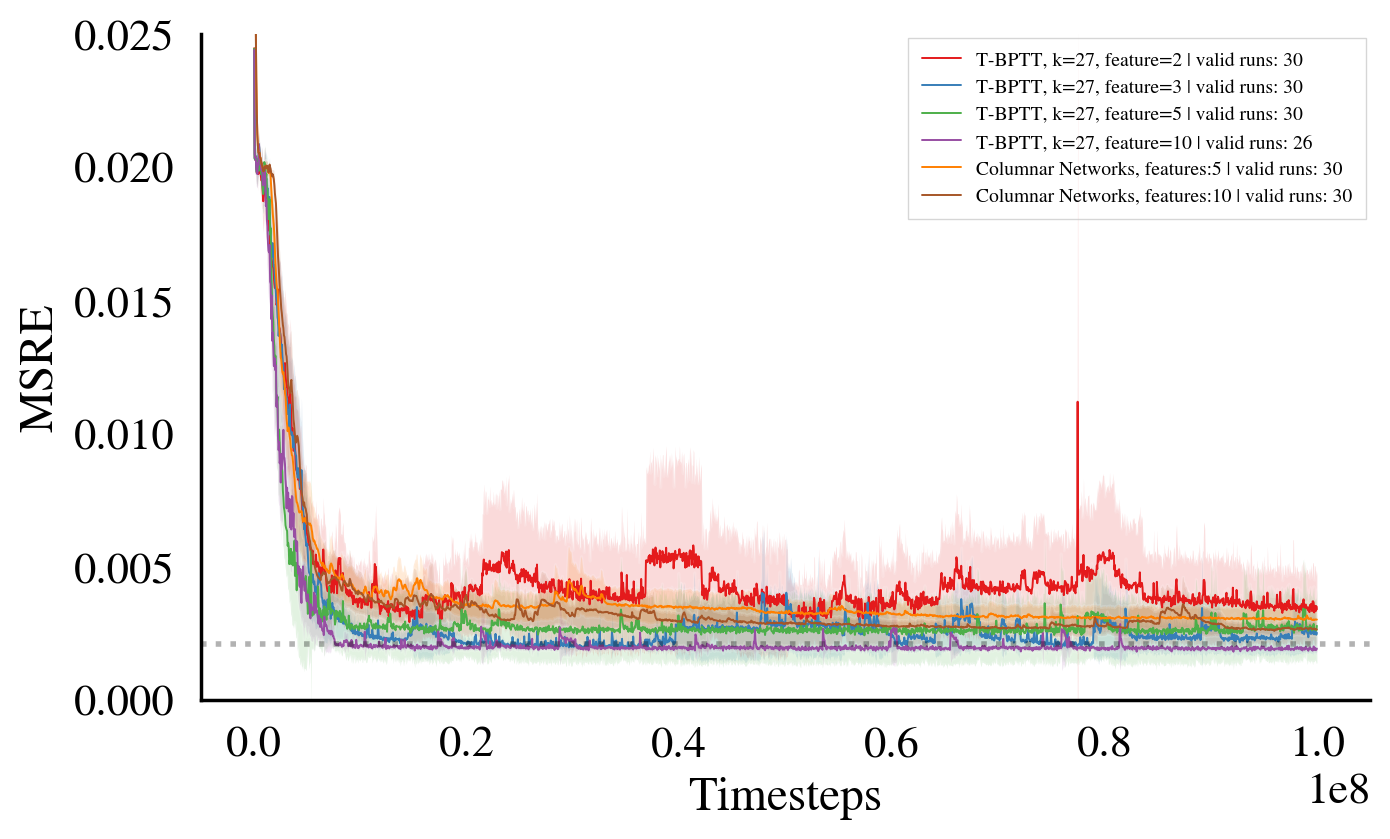

In [23]:

plt_name = f'Trace Conditioning Task'
fig = plt.figure(dpi=200)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
color_idx = 0

conditions = [['features', 2]]
plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=2", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1
conditions = [['features', 3]]
plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=3", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1
conditions = [['features', 5]]
plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=5", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1
conditions = [['features', 10]]
plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1

conditions = [['features', 5]]
plt_with_err("", 2000,0, db3, colors[color_idx], "Columnar Networks, features:5", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=2

conditions = [['features', 10]]
plt_with_err("", 2000,0, db3, colors[color_idx], "Columnar Networks, features:10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1


plt.axhline(y=0.0021, color='black', linestyle=':', linewidth=2, alpha=0.3)
legend = plt.legend(prop={'size': 7})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
fig.axes[0].set_ylim(bottom=0.00, top=0.025)
plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

	 Found 30 valid runs for [['features', 2]]
	 Found 30 valid runs for [['features', 5]]


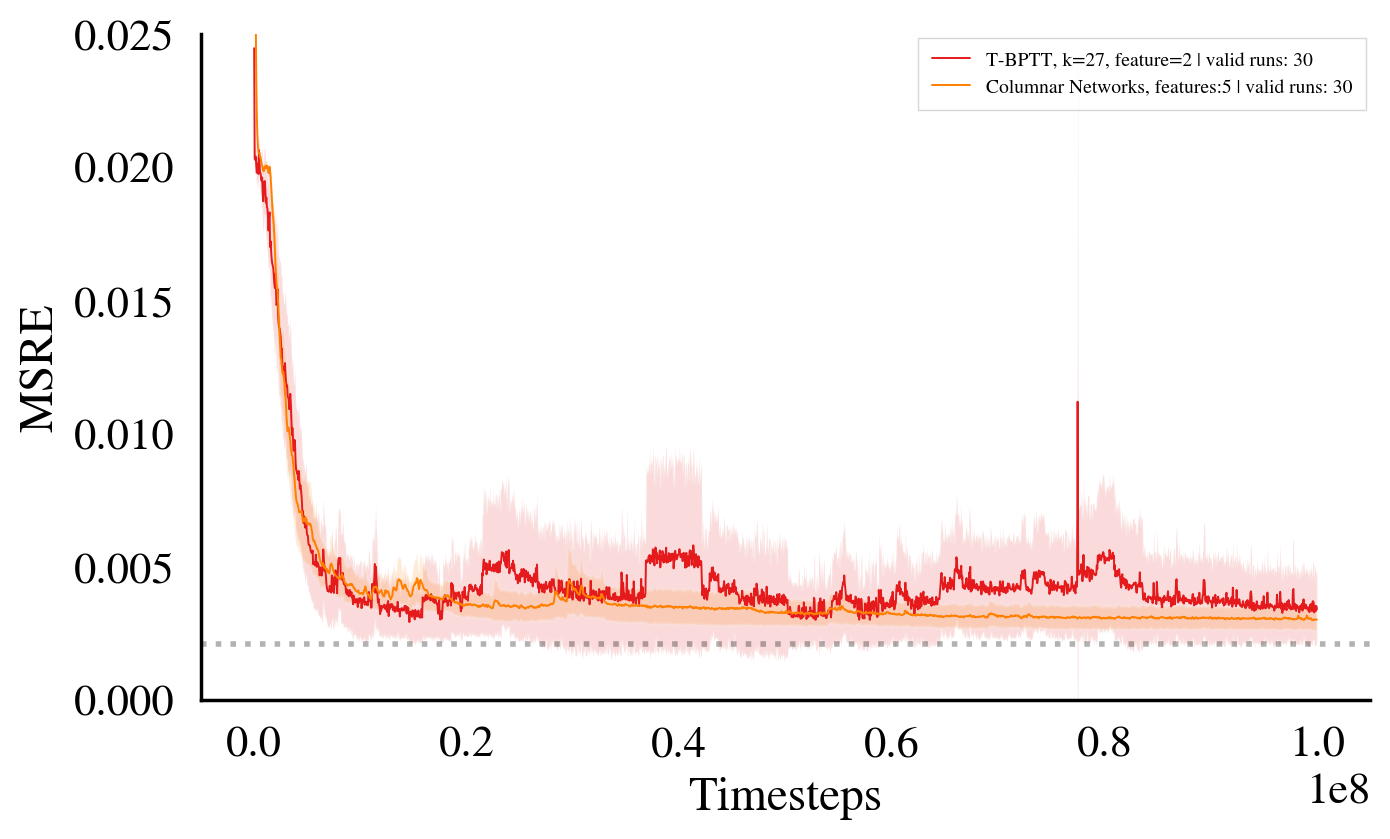

In [25]:

plt_name = f'Trace Conditioning Task'
fig = plt.figure(dpi=200)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
color_idx = 0

conditions = [['features', 2]]
plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=2", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1
conditions = [['features', 3]]
#plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=3", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1
conditions = [['features', 5]]
#plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=5", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1
conditions = [['features', 10]]
#plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1

conditions = [['features', 5]]
plt_with_err("", 2000,0, db3, colors[color_idx], "Columnar Networks, features:5", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=2

conditions = [['features', 10]]
#plt_with_err("", 2000,0, db3, colors[color_idx], "Columnar Networks, features:10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1


plt.axhline(y=0.0021, color='black', linestyle=':', linewidth=2, alpha=0.3)
legend = plt.legend(prop={'size': 7})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
fig.axes[0].set_ylim(bottom=0.00, top=0.025)
plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

	 Found 30 valid runs for [['features', 3]]
	 Found 30 valid runs for [['features', 10]]


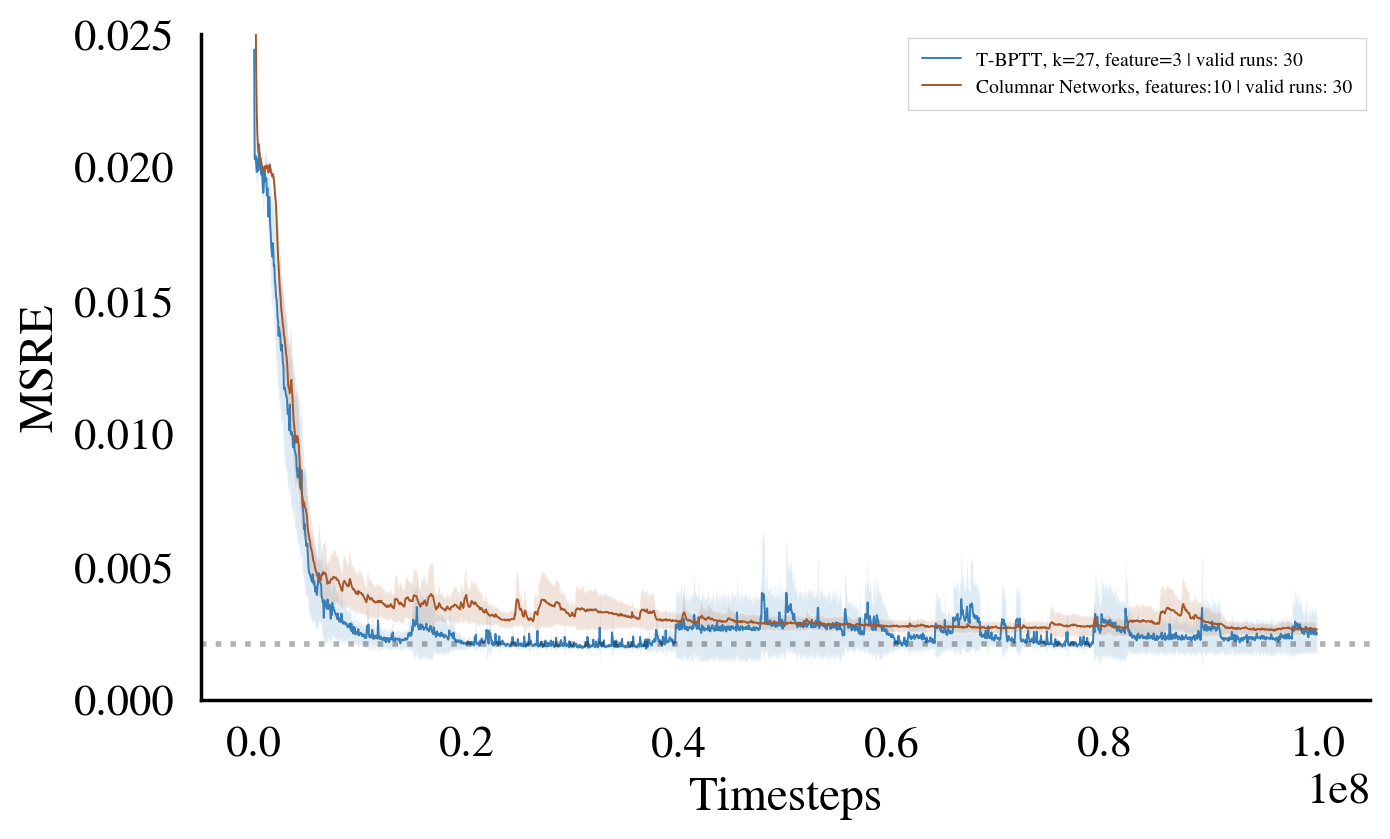

In [26]:

plt_name = f'Trace Conditioning Task'
fig = plt.figure(dpi=200)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
color_idx = 0

conditions = [['features', 2]]
#plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=2", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1
conditions = [['features', 3]]
plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=3", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1
conditions = [['features', 5]]
#plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=5", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1
conditions = [['features', 10]]
#plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1

conditions = [['features', 5]]
#plt_with_err("", 2000,0, db3, colors[color_idx], "Columnar Networks, features:5", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=2

conditions = [['features', 10]]
plt_with_err("", 2000,0, db3, colors[color_idx], "Columnar Networks, features:10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1


plt.axhline(y=0.0021, color='black', linestyle=':', linewidth=2, alpha=0.3)
legend = plt.legend(prop={'size': 7})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
fig.axes[0].set_ylim(bottom=0.00, top=0.025)
plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

	 Found 30 valid runs for [['features', 2]]
	 Found 30 valid runs for [['features', 3]]
	 Found 30 valid runs for [['features', 5]]
	 Found 26 valid runs for [['features', 10]]
	 Found 30 valid runs for [['features', 5]]
	 Found 30 valid runs for [['features', 10]]


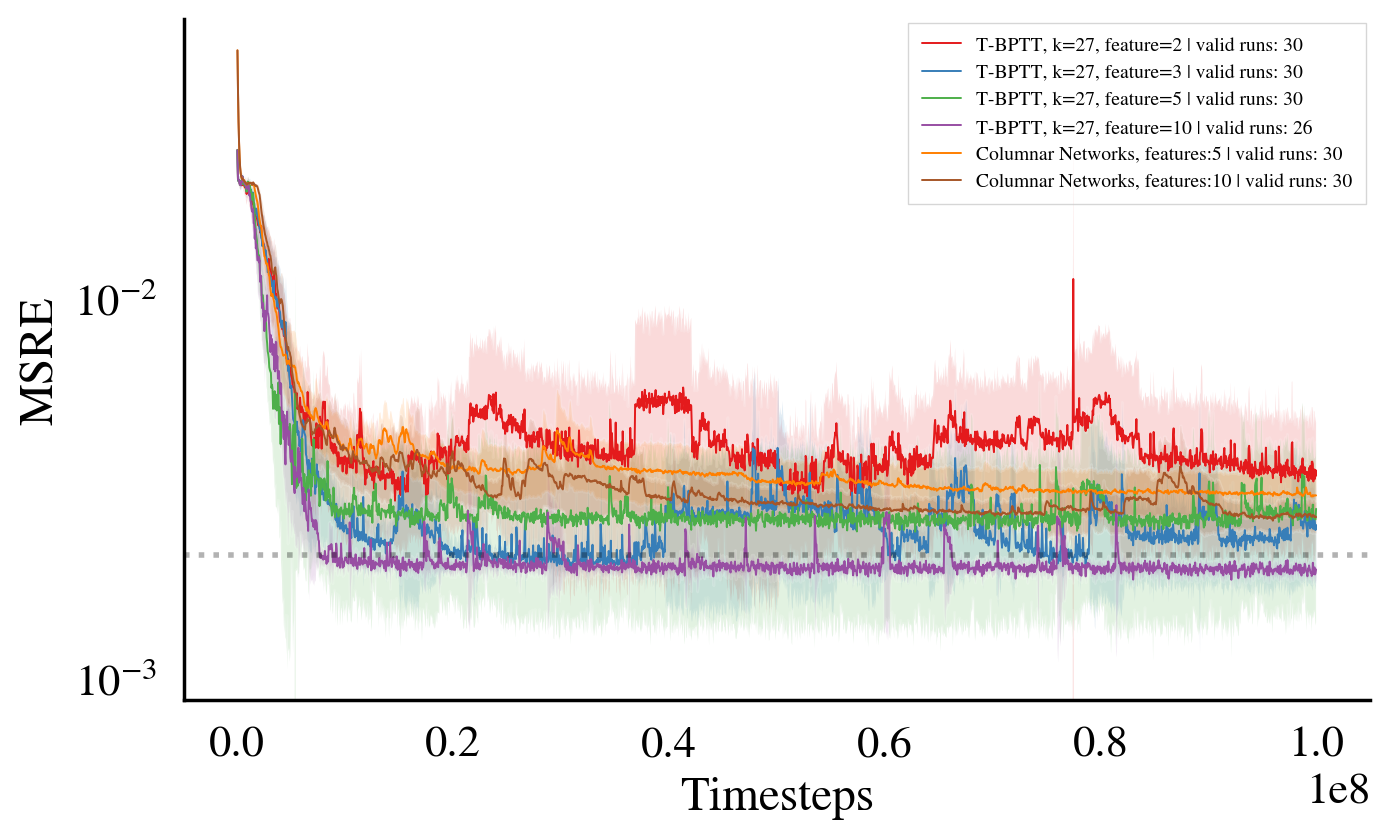

In [24]:

plt_name = f'Trace Conditioning Task'
fig = plt.figure(dpi=200)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
color_idx = 0

conditions = [['features', 2]]
plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=2", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1
conditions = [['features', 3]]
plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=3", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1
conditions = [['features', 5]]
plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=5", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1
conditions = [['features', 10]]
plt_with_err("", 2000, 0, db4, colors[color_idx], "T-BPTT, k=27, feature=10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1

conditions = [['features', 5]]
plt_with_err("", 2000,0, db3, colors[color_idx], "Columnar Networks, features:5", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=2

conditions = [['features', 10]]
plt_with_err("", 2000,0, db3, colors[color_idx], "Columnar Networks, features:10", conditions, "error_table", True, pkey_col = "run", nocomment=True, linewidth=0.7)
color_idx+=1


plt.axhline(y=0.0021, color='black', linestyle=':', linewidth=2, alpha=0.3)
legend = plt.legend(prop={'size': 7})
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('log')
#fig.axes[0].set_ylim(bottom=0.00, top=0.025)
plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

# Prediction plots
Same colors as above

In [17]:
def plot_last_n_paper(obsall, predall, targets, n=400, colortarget=None, colorpred=None):
    fig, axs = plt.subplots(2,figsize=(7.2, 4.45), dpi=200)
    fig.tight_layout()#(7.2,4.45)
    axs[-2].step(list(range(n)), targets[-n:], color=colortarget)
    axs[-1].step(list(range(n)), predall[-n:], color=colorpred)
    axs[-2].set_ylabel('Target')
    axs[-1].set_ylabel('Prediction')
    axs[-1].set_xlabel('Timestep')

    for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
        ax.label_outer()
    return fig

In [18]:
def plot_last_n_paper(n=800, db=None, condition=None, colortarget=None, colorpred=None, axs=None, seed=0):
    # too lazy
    seed = seed
    pkey_col = 'run'
    if condition == []:
        r = pd.read_sql(f'select {pkey_col} from runs and seed=0', db.conn).values
    elif len(condition) == 1:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and seed={seed}', db.conn).values
    elif len(condition) == 2:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and seed={seed}', db.conn).values
    elif len(condition) == 3:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and seed={seed}', db.conn).values
    elif len(condition) == 4:
        r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and seed={seed}', db.conn).values
    run = r[0][0]
    pred_table = pd.read_sql(f'select * from predictions where run={run}', db.conn)
    #obs = pred_table.values[:,2:9]
    pred = pred_table.values[:,-2]
    target = pred_table.values[:,-1]

    axs.step(list(range(n)), target[-n:], color=colortarget, alpha=0.2)
    axs.step(list(range(n)), pred[-n:], color=colorpred)
    #axs.set_ylabel('Target')
    #axs.set_ylabel('Prediction')
    #axs.set_xlabel('Timestep')

    #for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
    #    ax.label_outer()
    return fig, pred, target

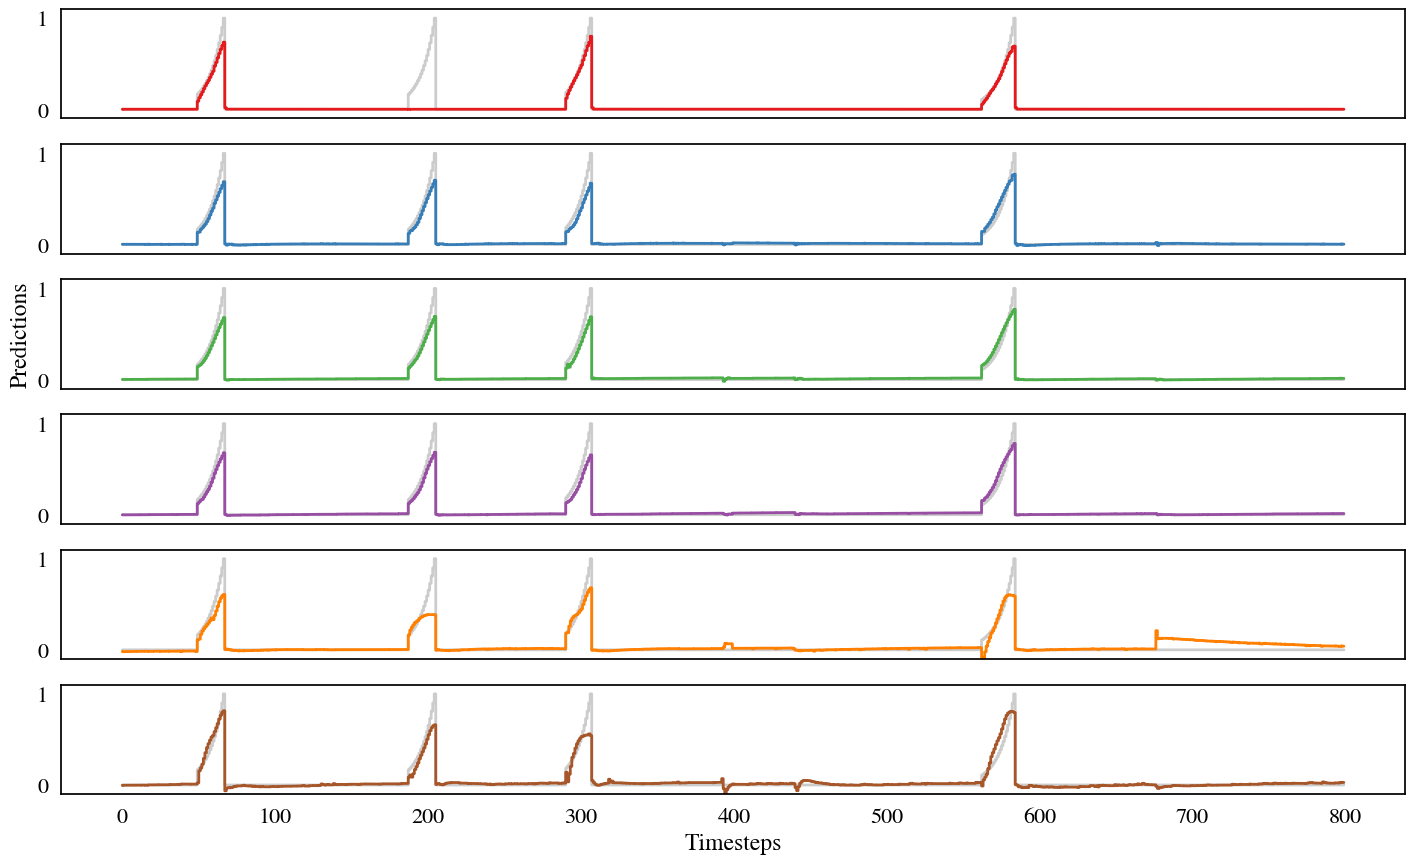

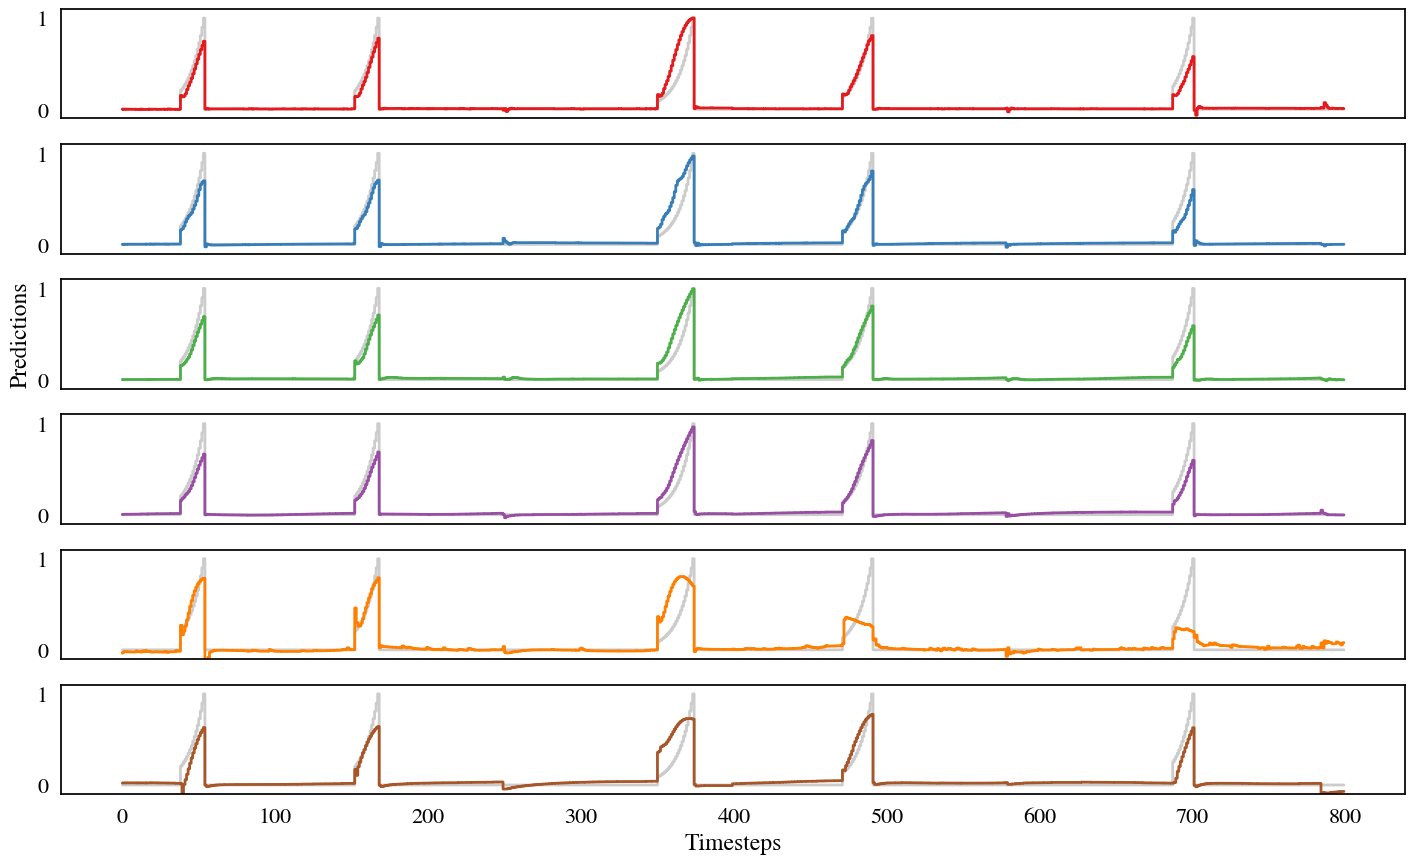

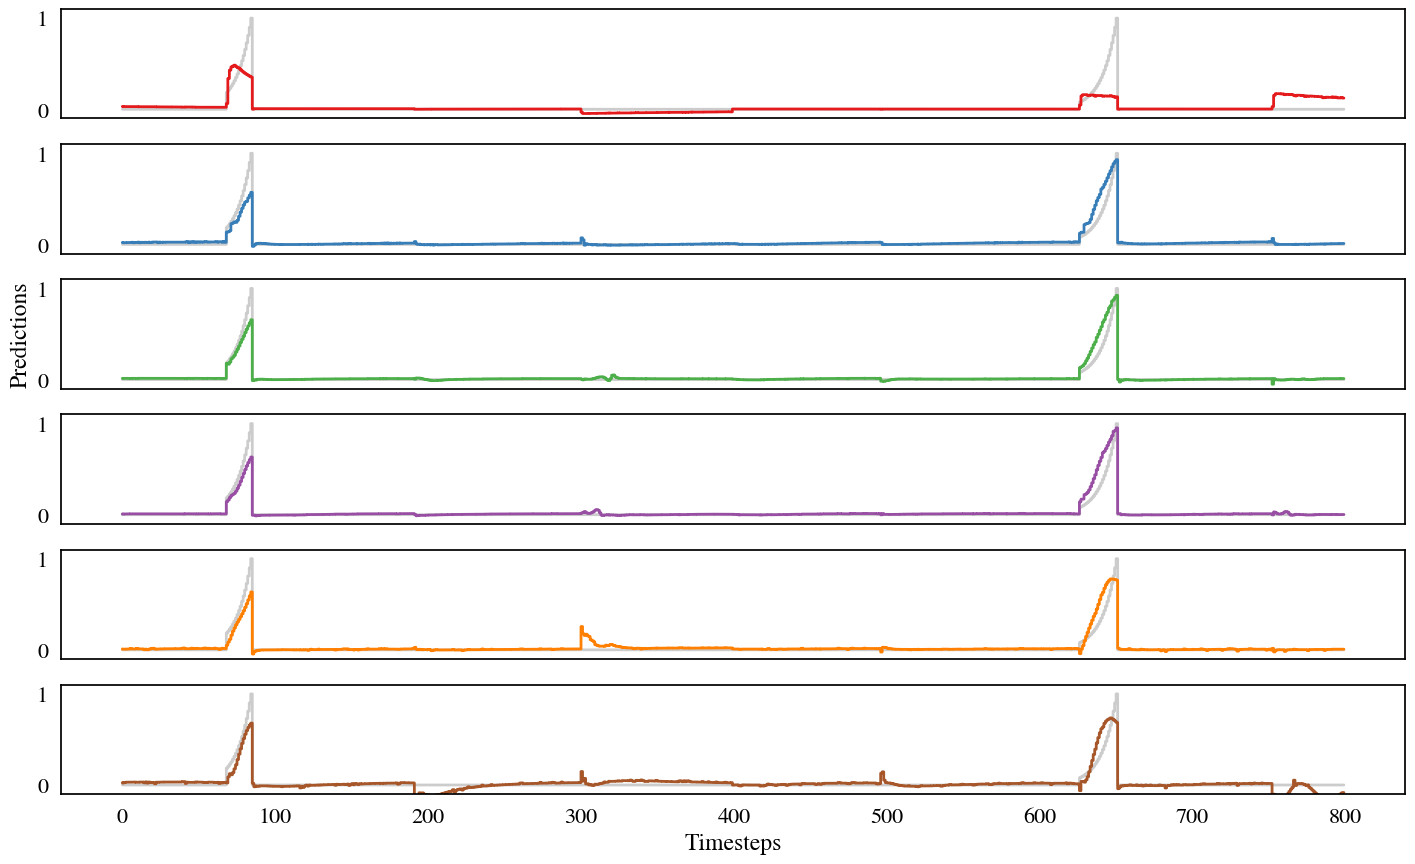

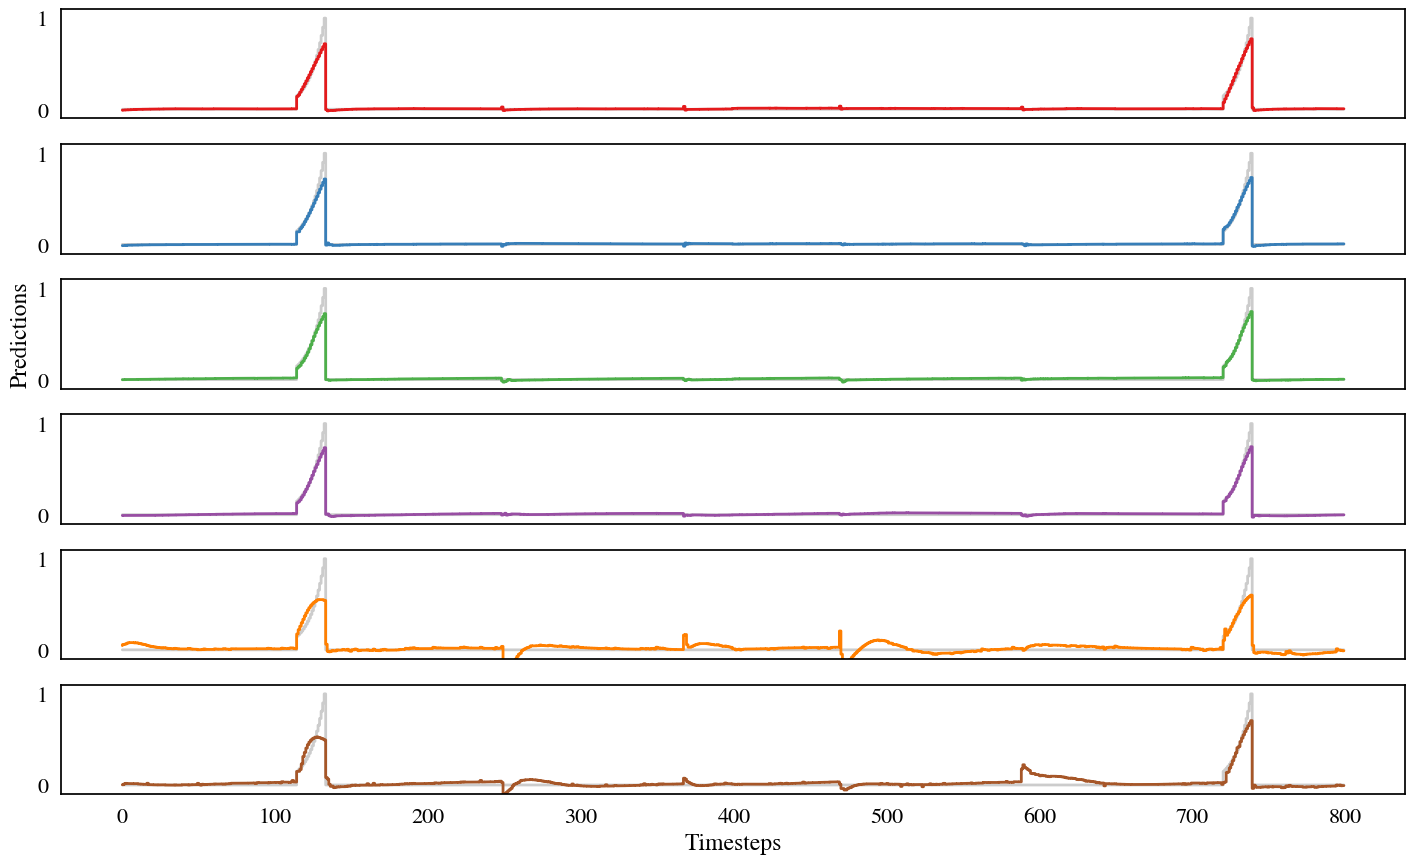

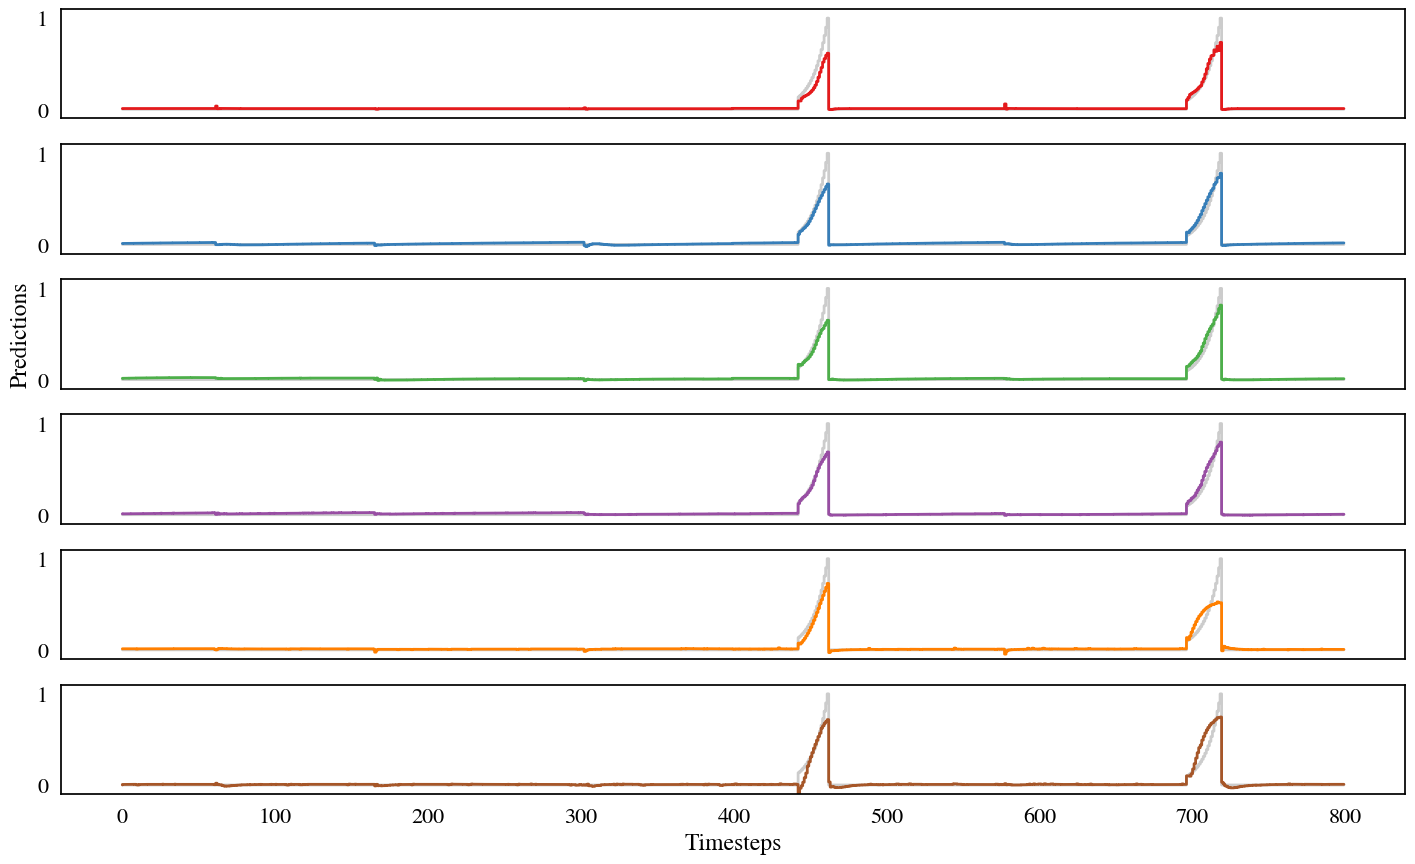

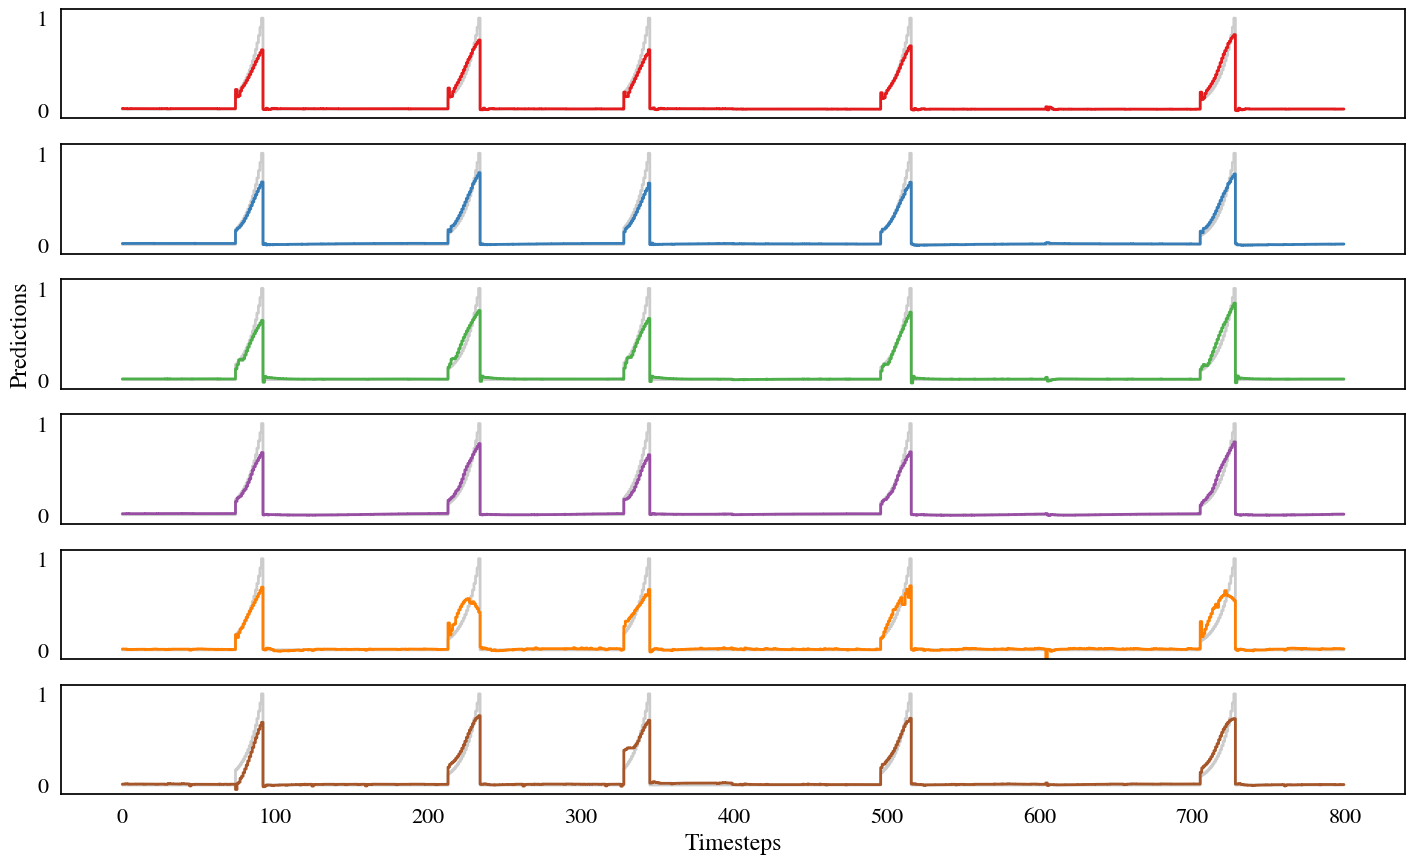

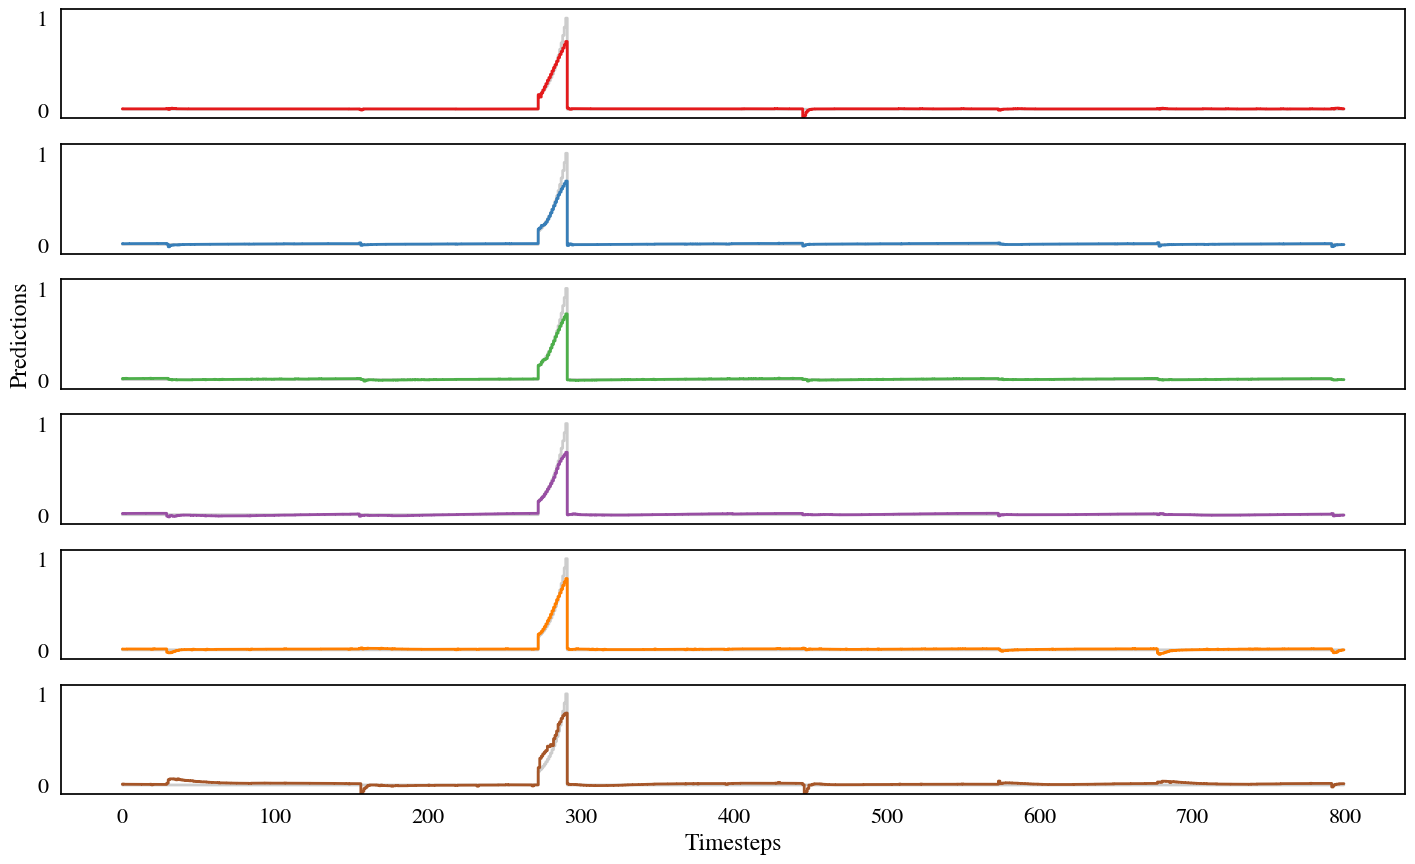

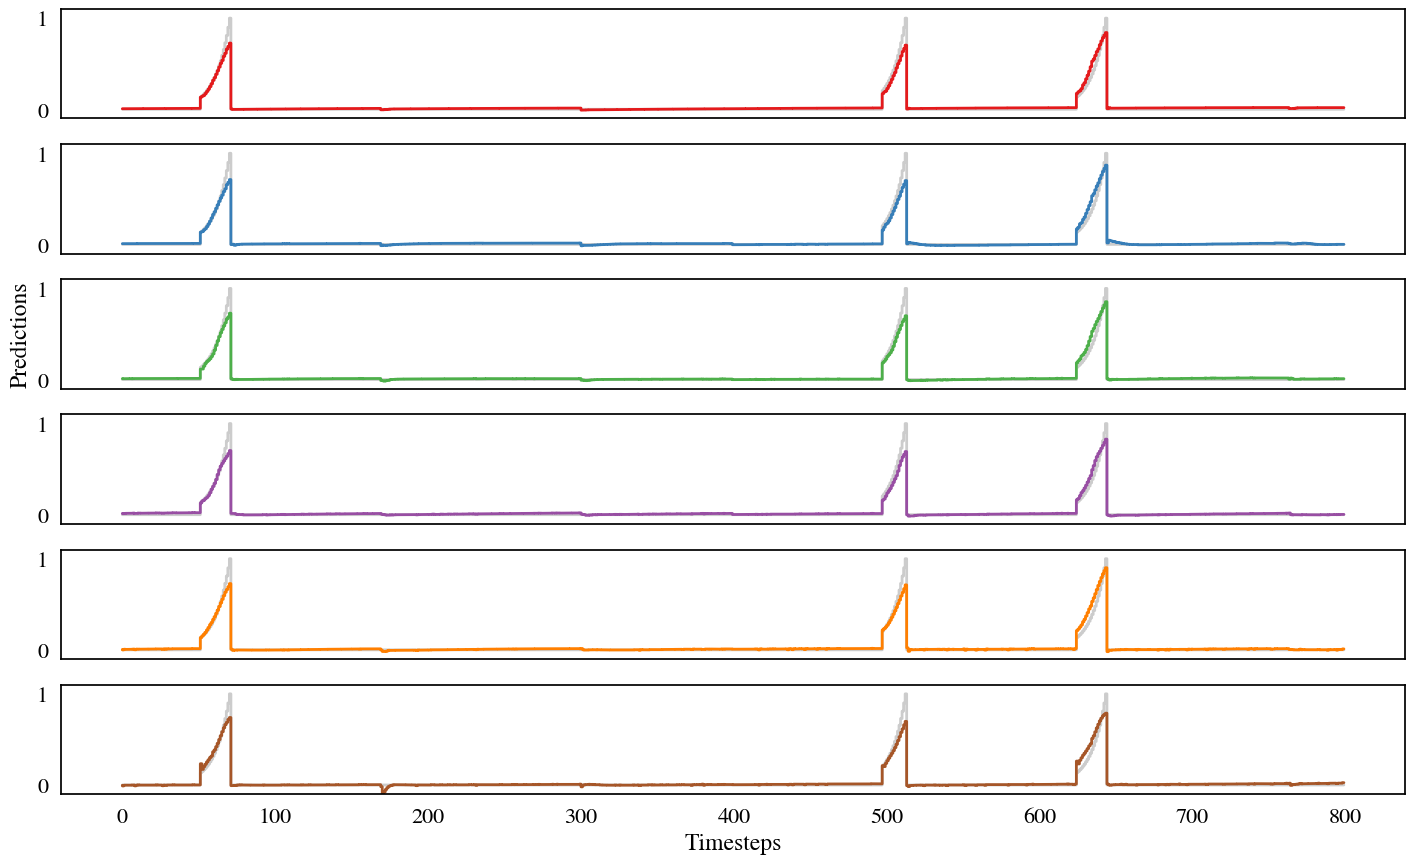

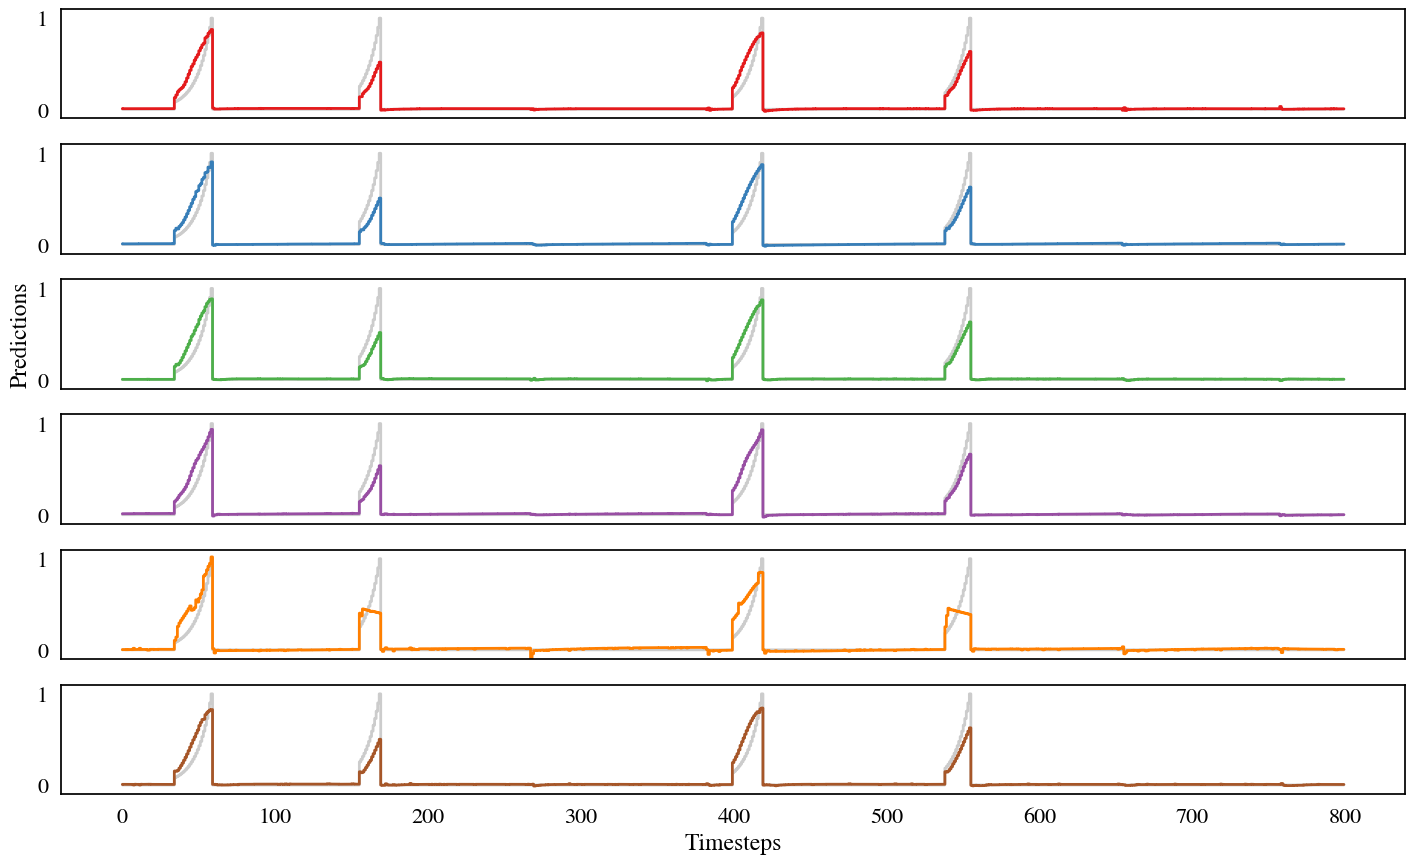

In [19]:
colors = plt.cycler(color=sns.color_palette("Set1",  n_colors=9)).by_key()['color']

for seed in [0,1,2,3,4,5,6,7,8]:
    fig, axs = plt.subplots(6,figsize=(14.4, 8.9), dpi=100)
    fig.tight_layout()
    """
    conditions = [['width', 20],
                 ['lambda', 0.99],
                 ['step_size', 1e-2],
                 ['freq', 800000]]
    colors = plt.cycler(color=sns.color_palette("Set1", n_colors=9)).by_key()['color']
    run = pd.read_sql(f'select run from runs where {conditions[0][0]} = {conditions[0][1]} and {conditions[1][0]} = {conditions[1][1]}  and {conditions[2][0]} = {conditions[2][1]}  and {conditions[3][0]} = {conditions[3][1]}', db2.conn).values[0][0]
    pred_table = pd.read_sql(f'select * from predictions where run={run}', db2.conn)
    obs = pred_table.values[:,2:9]
    pred = pred_table.values[:,9]
    target = pred_table.values[:,10]
    plot_last_n_paper(obs, pred, target, colortarget=colors[6], colorpred=colors[4], axs=axs[0])
    plot_last_n_paper(obs, pred, target, colortarget=colors[7], colorpred=colors[4], axs=axs[1])
    #plt.suptitle('Hybrid NNs')
    """

    color_idx = 0

    conditions = [['features', 2]]
    plot_last_n_paper(db=db4, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[0], seed=seed)
    color_idx+=1
    
    conditions = [['features', 3]]
    plot_last_n_paper(db=db4, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[1], seed=seed)
    color_idx+=1
    
    conditions = [['features', 5]]
    plot_last_n_paper(db=db4, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[2], seed=seed)
    color_idx+=1
    
    conditions = [['features', 10]]
    plot_last_n_paper(db=db4, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[3], seed=seed)
    color_idx+=1
    
    conditions = [['features', 5]]
    plot_last_n_paper(db=db3, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[4], seed=seed)
    color_idx+=2

    conditions = [['features', 10]]
    plot_last_n_paper(db=db3, condition=conditions, colortarget="black", colorpred=colors[color_idx], axs=axs[5], seed=seed)
    color_idx+=1
                  
    for ax in axs:
        #ax.grid(color='#666666', linestyle='-', alpha=0.5)
        ax.label_outer()
        ax.set_ylim(bottom=-0.1, top=1.1)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
    axs[2].set_ylabel("Predictions")
    plt.xlabel("Timesteps")
    plt.savefig('figures/plt_mnist_preds.svg', bbox_inches='tight')